# Machine Learning Model Implementations
This file includes machine learning model implementations and their results on the processed data set.
The models used in order is as follows:
1. Grid Search
2. Gradient Descent
3. KNN (with DTW and MSE)
4. Naive Bayes
5. Decision Tree

### Import Packages and Load Dataset

Labels come from 2 different PSG systems: Remlogic and Somnomedics. EMFIT is the piezoelectric mat and Somnofy is the radar. Sleep stage labels are as follows:

0 = Awake \
1 = REM \
2 = Light \
3 = Deep

In [4]:
# Please run if tslearn package is not included
# !pip3 install tslearn

In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from tslearn.metrics import dtw
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import numpy as np
from loader import *
from helpers import *

In [2]:
x, y, _, _ = get_nn_patients()
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.30, shuffle = False, stratify = None)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((35, 857, 2), (15, 857, 2), (35, 857), (15, 857))

In [3]:
x_all, y_all = x.reshape(x.shape[0] * x.shape[1], 2), y.ravel()
overall_balanced_accuracy(x_all, y_all)

Radar:   Acc =  0.6300419179017127
Mat:   Acc =  0.4167082563479184


### Grid Search

In [6]:
x_tr_radar, x_tr_emfit = x_tr[:,:,0].T, x_tr[:,:,1].T
x_te_radar, x_te_emfit = x_te[:,:,0].T, x_te[:,:,1].T
y_tr_gd, y_te_gd = y_tr.T, y_te.T
truth = y_te_gd.ravel()
x_tr_radar.shape, x_tr_emfit.shape, x_te_radar.shape, x_te_emfit.shape, y_tr_gd.shape, y_te_gd.shape

((857, 35), (857, 35), (857, 16), (857, 16), (857, 35), (857, 16))

In [5]:
def grid_search(radar, mat, psg, step=0.002, grid_limit=0.6):
    loss=100
    w_opt=np.zeros((2,1), dtype=float)
    w = np.zeros((2,1), dtype=float)
    while w[0] <= grid_limit:
        w[1]=0
        while w[1] <= grid_limit:
            e=np.zeros((radar.shape[0],radar.shape[1]))
            for i in range(radar.shape[1]):
                e[:,i]=(psg[:,i].reshape(radar.shape[0],1)-np.c_[mat[:,i],radar[:,i]].reshape(radar.shape[0],2)@w).reshape(radar.shape[0],)
            mse=np.zeros((radar.shape[1],1))
            for i in range(radar.shape[1]):
                mse[i]=1/2/radar.shape[0]*e[:,i].T@e[:,i]
            average_mse=np.mean(mse)
            if average_mse<loss:
                loss=average_mse
                w_opt[0], w_opt[1] = w[0], w[1]
            w[1]+=step
        w[0]+=step
    return w_opt

In [7]:
w = grid_search(x_tr_radar, x_tr_emfit, y_tr_gd, step=0.002, grid_limit=.8)
preds = get_predictions(w, x_te_emfit, x_te_radar).ravel() 

              precision    recall  f1-score   support

         0.0       0.83      0.35      0.49      3679
         1.0       0.29      0.80      0.43      1920
         2.0       0.61      0.66      0.63      6382
         3.0       0.00      0.00      0.00      1731

    accuracy                           0.51     13712
   macro avg       0.43      0.45      0.39     13712
weighted avg       0.55      0.51      0.49     13712

Balanced accuracy: 0.45229832093907046
Accuracy: 0.51188739789965


/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


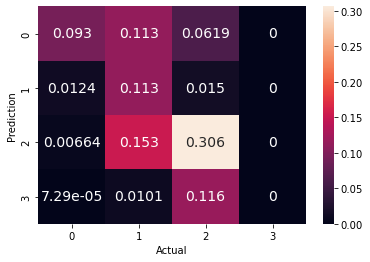

In [12]:
print(classification_report(truth,preds))
print("Balanced accuracy:", balanced_accuracy_score(truth,preds))
print("Accuracy:",accuracy_score(truth,preds))
plot_conf_matrix(preds, truth, normalize = True)

### Gradient Descent

In [7]:
size = x_tr_radar.shape[0]
psg = np.zeros((size,1))
for i in range(size):
    psg[i]=round(np.mean(y_tr_gd[i,:]))
emfit_mean=np.zeros((size,1))
for i in range(size):
    emfit_mean[i]=np.mean(x_tr_emfit[i,:])
somnofy_mean=np.zeros((size,1))
for i in range(size):
    somnofy_mean[i]=np.mean(x_tr_radar[i,:])

w, loss_m1= mse_gd(emfit_mean, somnofy_mean, psg, max_iters=1500, gamma=0.005,w0=True)

In [8]:
preds = get_predictions(w, x_te_emfit, x_te_radar).ravel()

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.83      0.35      0.49      3679
         1.0       0.29      0.80      0.43      1920
         2.0       0.61      0.66      0.63      6382
         3.0       0.00      0.00      0.00      1731

    accuracy                           0.51     13712
   macro avg       0.43      0.45      0.39     13712
weighted avg       0.55      0.51      0.49     13712

Balanced accuracy: 0.45229832093907046
Accuracy: 0.51188739789965
[0.34656157 0.8046875  0.65794422 0.        ]


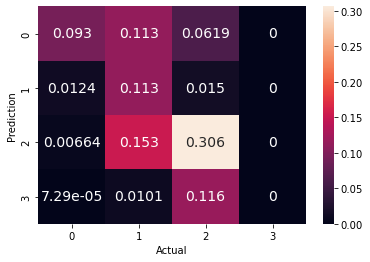

In [9]:
print(classification_report(truth,preds))
print("Balanced accuracy:", balanced_accuracy_score(truth,preds))
print("Accuracy:",accuracy_score(truth,preds))
plot_conf_matrix(preds, truth, normalize = True)

# Data preparation for the rest

In [4]:
train_size, test_size = x_tr.shape[0] * x_tr.shape[1], x_te.shape[0] * x_te.shape[1]
x_tr, x_te, y_tr, y_te = x_tr.reshape(train_size,2), x_te.reshape(test_size,2), y_tr.ravel(), y_te.ravel()

### KNN Classifier

#### KNN with Dynamic Time Wraping from tslearn

In [12]:
knn_classifier = KNeighborsClassifier(n_neighbors=10, metric=dtw, n_jobs=-1)
knn_classifier.fit(x_tr, y_tr)

KNeighborsClassifier(metric=<function dtw at 0x7f839933bee0>, n_jobs=-1,
                     n_neighbors=10)

In [ ]:
preds = knn_classifier.predict(x_te)

In [ ]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)

#### KNN with MSE

In [5]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(x_tr, y_tr)
preds = knn_classifier.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      3639
         1.0       0.59      0.37      0.45      1606
         2.0       0.64      0.74      0.68      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.65     12855
   macro avg       0.64      0.58      0.60     12855
weighted avg       0.65      0.65      0.65     12855

Balanced accuracy: 0.5844355266033772
Accuracy: 0.6513418903150525
Accuracy per class: [0.6784831  0.36924035 0.73766103 0.55235762]


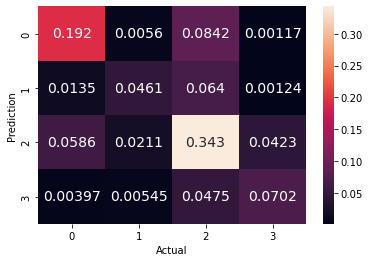

In [6]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)

### Naive Bayes 

In [7]:
cnb_classifier = CategoricalNB()
cnb_classifier.fit(x_tr, y_tr)

CategoricalNB()

In [8]:
preds = cnb_classifier.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.72      0.63      0.68      3639
         1.0       0.63      0.68      0.65      1606
         2.0       0.68      0.73      0.70      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.67     12855
   macro avg       0.66      0.65      0.65     12855
weighted avg       0.68      0.67      0.67     12855

Balanced accuracy: 0.6491210336707802
Accuracy: 0.6749902761571372
Accuracy per class: [0.63369057 0.67745953 0.73297641 0.55235762]


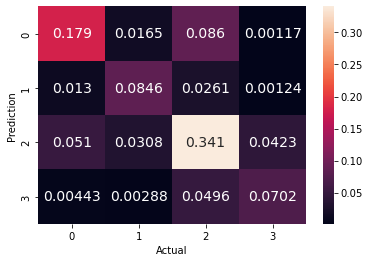

In [9]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)

### Decision Tree

In [10]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(x_tr, y_tr) 
preds = classifier_feature.predict(x_te)

              precision    recall  f1-score   support

         0.0       0.73      0.63      0.68      3639
         1.0       0.62      0.68      0.65      1606
         2.0       0.68      0.73      0.70      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.67     12855
   macro avg       0.66      0.65      0.65     12855
weighted avg       0.68      0.67      0.67     12855

Balanced accuracy: 0.6485506278240203
Accuracy: 0.674679113185531
Accuracy per class: [0.62956856 0.67745953 0.7348168  0.55235762]


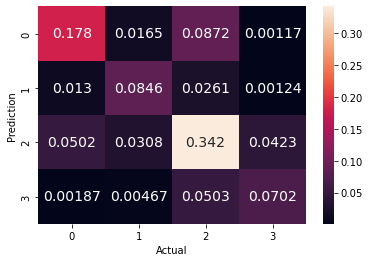

In [11]:
print(classification_report(y_te,preds))
print("Balanced accuracy:", balanced_accuracy_score(y_te,preds))
print("Accuracy:",accuracy_score(y_te,preds))
plot_conf_matrix(preds, y_te, normalize = True)